# Comparison of Different Optimizers for QAOA (Max Cut)
In this notebook different optimizers for the QAOA parameters are compared. The approximation ratios obtained by using the different optimizers are compared, as well as the value of the QAOA parameters. 

# Importing necessary modules

In [1]:
from qaoa import QAOA, problems, mixers

In [2]:
from qiskit import *
import numpy as np
import networkx as nx

import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator
from qiskit.visualization import *
from qiskit_algorithms.optimizers import SPSA, QNSPSA, COBYLA, NELDER_MEAD

# Creating problem instance
Data for graph generation is found at https://github.com/OpenQuantumComputing/data

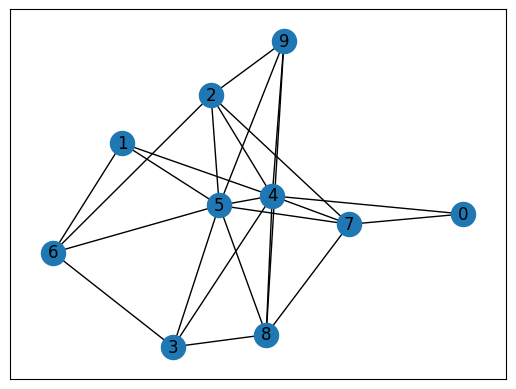

In [3]:
numV=10 #Number of vertices
G = nx.read_gml("../../../data/sample_graphs/w_ba_n"+str(numV)+"_k4_0.gml")
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=pos)
mincost=-8.657714089848158

# Setting up the optimizers to use roughly the same number of function evaluations

In [4]:
optimizers={}
plotstyle={}

settings = {
    "maxiter": 70,
    "blocking": True,
    "allowed_increase": 0,
    "second_order": True,
    "regularization": 0.01
}
optimizers["spsa"] = [SPSA, settings.copy()]
plotstyle["spsa"] = '+-'

settings = {
    "maxiter": 50,
    "blocking": True,
    "allowed_increase": 0,
    "learning_rate": 0.02,
    "perturbation": 0.05,
    "regularization": 0.01,
    "hessian_delay": 0
}
optimizers["qnspsa"] = [QNSPSA, settings.copy()]
plotstyle["qnspsa"] = 'o-'

settings = {
    "maxiter": 110,
    "tol": 1e-6 
}
optimizers["neldermead"] = [NELDER_MEAD, settings.copy()]
plotstyle["neldermead"] = 'x-'

settings = {
    "maxiter": 350,
    "tol": 1e-6 
}
optimizers["cobyla"] = [COBYLA, settings.copy()]
plotstyle["cobyla"] = '*-'

# Creating a QAOA instance for each optimizer

In [5]:
qaoa={}
for key in optimizers:
    qaoa[key] = QAOA(
    problem=problems.MaxCut,
    mixer=mixers.Unconstrained,
    params={'G' : G, 'optimizer' : optimizers[key]}
)

# Sample cost landscape for each QAOA instance

In [6]:
for key in optimizers:
    qaoa[key].sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})

2023-09-11 14:30:15 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:15 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:15 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:15 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-11 14:30:16 

# Plotting the cost landscape
The cost landscape is of course the same for all the optimizer methods and is plotted below.

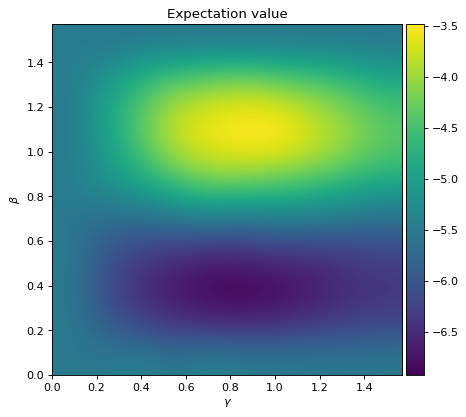

In [7]:
method = "cobyla"

f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoa[method].E,interpolation='bicubic',origin='lower',extent=[0,np.pi/2,0,np.pi/2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)

# Increasing depth for each QAOA instance

In [8]:
maxdepth=10
for i in range(maxdepth):
    for key in optimizers:
        qaoa[key].increase_depth()

2023-09-11 14:30:29 [info     ] cost(depth 1 = -6.917675130462551 file=qaoa.qaoa func=increase_depth
2023-09-11 14:30:40 [info     ] cost(depth 1 = -7.019429468247271 file=qaoa.qaoa func=increase_depth
2023-09-11 14:30:45 [info     ] cost(depth 1 = -7.006290943433828 file=qaoa.qaoa func=increase_depth
2023-09-11 14:30:46 [info     ] cost(depth 1 = -6.986409430926225 file=qaoa.qaoa func=increase_depth
2023-09-11 14:30:56 [info     ] cost(depth 2 = -7.462173799794936 file=qaoa.qaoa func=increase_depth
2023-09-11 14:31:10 [info     ] cost(depth 2 = -7.3694563610949615 file=qaoa.qaoa func=increase_depth
2023-09-11 14:31:15 [info     ] cost(depth 2 = -7.095380344032812 file=qaoa.qaoa func=increase_depth
2023-09-11 14:31:17 [info     ] cost(depth 2 = -7.335929547941457 file=qaoa.qaoa func=increase_depth
2023-09-11 14:31:27 [info     ] cost(depth 3 = -7.831265040228095 file=qaoa.qaoa func=increase_depth
2023-09-11 14:31:43 [info     ] cost(depth 3 = -7.655717014198877 file=qaoa.qaoa func=incr

# Plotting the approximation ratios
Below the approximation ratios are plotted for the different optimizers. From the figure we see that the different optimizers give roughly the same approximation ratio.

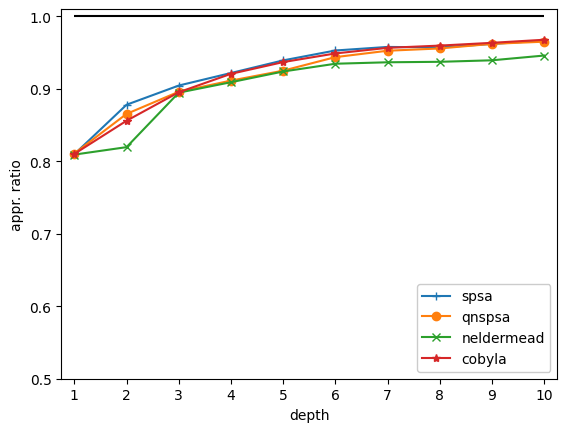

In [9]:
ax = pl.figure().gca()
pl.hlines(1, 1,maxdepth, linestyles="solid", colors="black")
for key in optimizers:
    pl.plot(np.arange(1,maxdepth+1), np.array(list(qaoa[key].costval.values()))/mincost, plotstyle[key], label=key)
pl.ylim(0.5,1.01)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('appr. ratio')
_=pl.xlabel('depth')
_=pl.legend(loc="lower right", framealpha=1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the values for the parameters
Below we plot the values for $\gamma$ and $\beta$ parameters found by the different optimizers. The values found are seen to be relatively similar for all the optimizers (except for an outlier at depth = 10 for the cobyla method). Importantly, the value for $\gamma$ is seen to be increasing with depth and the value of $\beta$ is seen to be decreasing with depth, in accordance with the heuristic strategy used to find the values for the parameters for increasing depth (see Quantum Approximate Optimization Algorithm: Performance, Mechanism, and Implementation on Near-Term Devices by Zhou et al.)

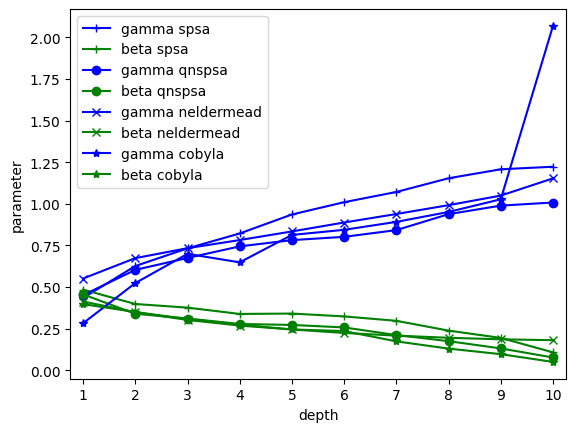

In [10]:
ax = pl.figure().gca()
for key in optimizers:
    pl.plot(np.arange(1,maxdepth+1),qaoa[key].angles_hist['d'+str(maxdepth)+'_final'][::2],"b"+plotstyle[key],label='gamma '+key)
    pl.plot(np.arange(1,maxdepth+1),qaoa[key].angles_hist['d'+str(maxdepth)+'_final'][1::2],"g"+plotstyle[key],label='beta '+key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('parameter')
_=pl.xlabel('depth')
_=pl.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# Plotting the number of function evaluations used by each optimizer
Below the number of function evaluations used by the different optimizers are plotted for increasing depths. 

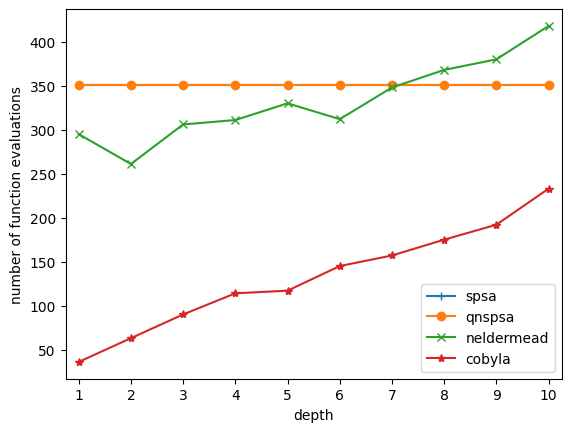

In [11]:
ax = pl.figure().gca()
for key in optimizers:
    _=pl.plot(np.arange(1,maxdepth+1),qaoa[key].num_fval.values(), plotstyle[key], label=key)
pl.xlim(1-.25,maxdepth+.25)
_=pl.ylabel('number of function evaluations')
_=pl.xlabel('depth')
_=pl.legend()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))